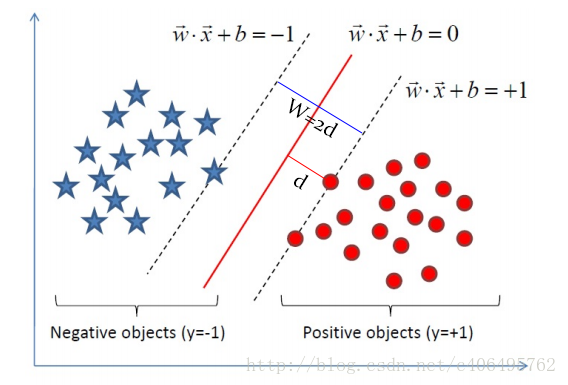

在样本空间中，划分超平面可通过如下线性方程来描述：

                        w*x+b=0,
            
其中w=(w1;w2;...;wd)为法向量，决定了超平面的方向；b为位移项，决定了超平面与原点之间的距离。

样本空间中任意点x到超平面(w,b)的距离可写为

                     r=|w*x+b|/||w||
                     
            

假设超平面(w,b)能将训练样本正确分类，即对于(xi,yi),若yi=+1,则w*xi+b>0;若yi=-1，则有w*xi+b<0，即存在一个数d，满足
                
                    w‘*xi+b>=d,yi=+1
                    w‘*xi+b<=d,yi=-1
                
                

等式两边做缩放变换，同除以d，得到

                    w*xi+b>=1,yi=+1
                    w*xi+b<=-1,yi=-1
                    
其中w=w'/d
                   

距离超平面最近的这几个训练样本使上式等号成立，它们被称为“支持向量”，两个异类支持向量到超平面的距离之和为

                    r=2/||w||
                    
它们被称为“间隔”                

欲找到具有“最大间隔”的划分超平面，也就是要找到满足上式的w和b，使得r最大。

                max 2/||w||
                s.t. yi*(w*xi+b)>=1

等价于

                min (1/2)*||w||^2
                s.t. yi*(w*xi+b)>=1
                
这就是支持向量机的基本型。